# HARK and SSJ example

By William Du (wdu9@jhu.edu) 


- This notebook demonstrates how HARK and the Sequence Space Jacobian toolkit can be combined to solve HANK models.

- HARK was designed to solve rich microeconomic models:
    - Lifecycle models
    - Discrete continuous choice
    - Portfolio choice. 
    
<br />

- SSJ was created to solve HANK models with incredibly speed and ease

- Connecting HARK to SSJ allows us to solve macro models with richer micro features.


# Model


To begin a basic HANK model is introduced. The model follows these lecture [SSJ slides](https://github.com/shade-econ/nber-workshop-2022/blob/main/Lectures/Lecture%204%20Fiscal%20Policy.pdf) from their heterogeneous agent workshop.


- Heterogenous agent households that consume/save into one asset. 

- Households face idiosyncratic income shocks.

- Cobb Douglas Production function with Labor.

- Sticky Wages

- Government taxes labor income, rolls over debt, to pay its expenditures.


# Bringing Model to Code

In [1]:
from ConsIndShockModel_HANK import IndShockConsumerType   # HARK Agent # HARK 13.0

from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc




In [2]:
import matplotlib.pyplot as plt
import numpy as np  # '1.22.0'
import time
from scipy import optimize # scipy version '1.10.0'
from copy import deepcopy


### Calibrate Steady State Values

In [3]:

#Steady state parameters
r_ss = .03 #Interest rate
G_ss = .2 # government spending
B_ss = .2 # government debt
Y_ss = 1.0 # output

T_ss = G_ss + r_ss*B_ss # Lump sum taxes
Z_ss = Y_ss - T_ss # after tax labor income
deficit_ss = G_ss - T_ss #deficit



In [4]:
HANK_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

In [5]:

def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function]


# Solve for Steady State

In [6]:
def ss_func(beta):
    
    HANK_Dict['DiscFac'] = beta
    Agent_func = IndShockConsumerType(**HANK_Dict, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 
start  = time.time()
Asset_target = B_ss

DiscFac = optimize.brentq(ss_dif,.85,.99)





In [7]:

# Create a HARK agent
HANK_Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**HANK_Dict, verbose = False)
A_ss, C_ss = Agent_GE.compute_steady_state()


In [8]:
print('goods_clearing', Y_ss - C_ss - G_ss)
print('asset_clearing', A_ss - B_ss)

goods_clearing 0.006249937499797353
asset_clearing 4.096500916261903e-12


## Compute Jacobians

In [9]:
start  = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',300)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor',300)

print('Time taken to compute jacobians', time.time() - start)

Time taken to compute jacobians 9.397560119628906


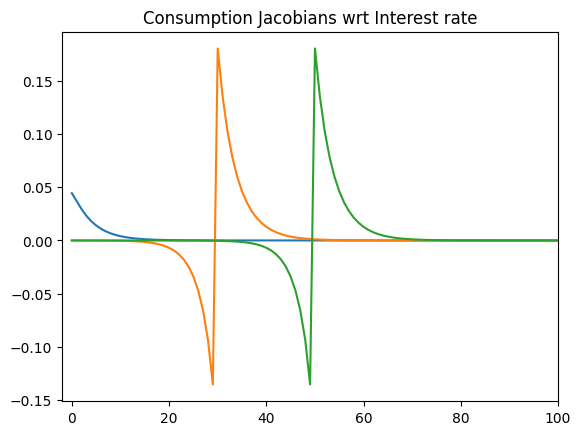

In [10]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[30])
plt.plot(CJACR.T[50])
plt.xlim(-2,100)
plt.title('Consumption Jacobians wrt Interest rate')
plt.show()

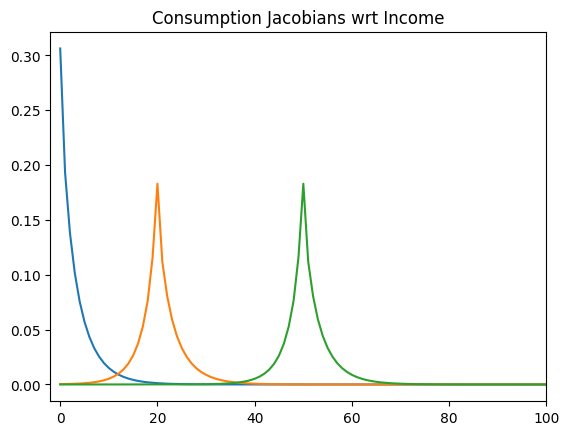

In [11]:
plt.plot(CJACZ.T[0])
plt.plot(CJACZ.T[20])
plt.plot(CJACZ.T[50])
plt.xlim(-2,100)
plt.title('Consumption Jacobians wrt Income')
plt.show()

# Specify Government Budget Constraint and Market Clearing Conditions

In [12]:
# Government Budget Constraint
@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit

#Market Clearing Conditions
@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    return asset_mkt, goods_mkt



In [13]:
# Store Jacobians in JacobianDict Object
Jacobian_Dict = JacobianDict( { 'C' : {'Z': CJACZ } ,
                                    
                                    'A' : {'Z': AJACZ } } )



In [14]:
# Construct SteadyStateDict object
SteadyState_Dict = SteadyStateDict({"asset_mkt":0.0,
                                    "goods_mkt":0.0,
                                    "deficit": G_ss - T_ss,
                                    "B": B_ss, # Gov. Debt
                                    "r": r_ss, # Interest rate
                                    "G": G_ss, # Gov. Spending
                                    "Y": Y_ss, # Output
                                    "A": B_ss, # Assets
                                    "C": C_ss, # Consumption
                                    "Z": Y_ss - T_ss, # Income (post-tax)
                                    "T": T_ss,        # Lump Sum Taxes
                                   })

In [15]:

T = 300  # <-- the length of the IRF
rho_G = 0.8 # peristence of shock
dG = .01 * rho_G ** np.arange(T)
shocks = {'G': dG}

unknowns_td = ['Y']
targets_td = ['asset_mkt']

# Create model
ha_lin = sj.create_model([Jacobian_Dict,fiscal,mkt_clearing], name="HA Model")

# obtain impulse responses
irfs_G_lin = ha_lin.solve_impulse_linear(SteadyState_Dict, unknowns_td, targets_td, shocks)


In [16]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

## Government Spending Shock (Balanced Budget)

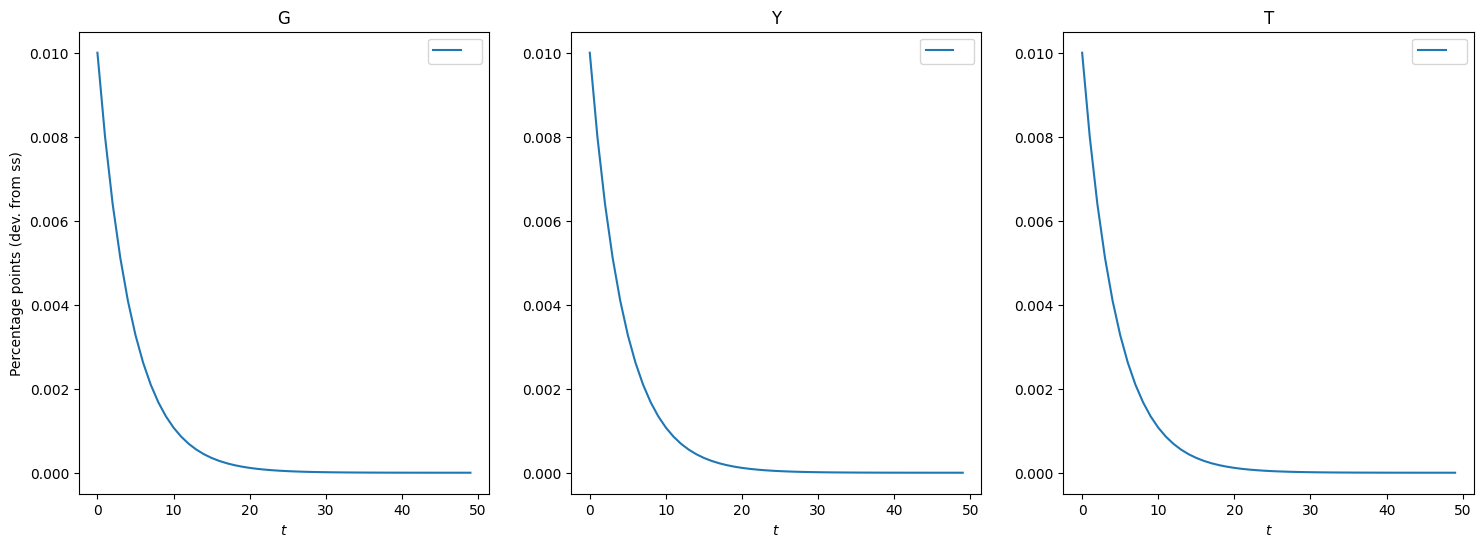

In [17]:
show_irfs([irfs_G_lin], ['G', 'Y','T'])

## Government Spending shock (deficit financed)

In [18]:

rho_B = 0.9
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B_lin = ha_lin.solve_impulse_linear(SteadyState_Dict, unknowns_td, targets_td, shocks_B)

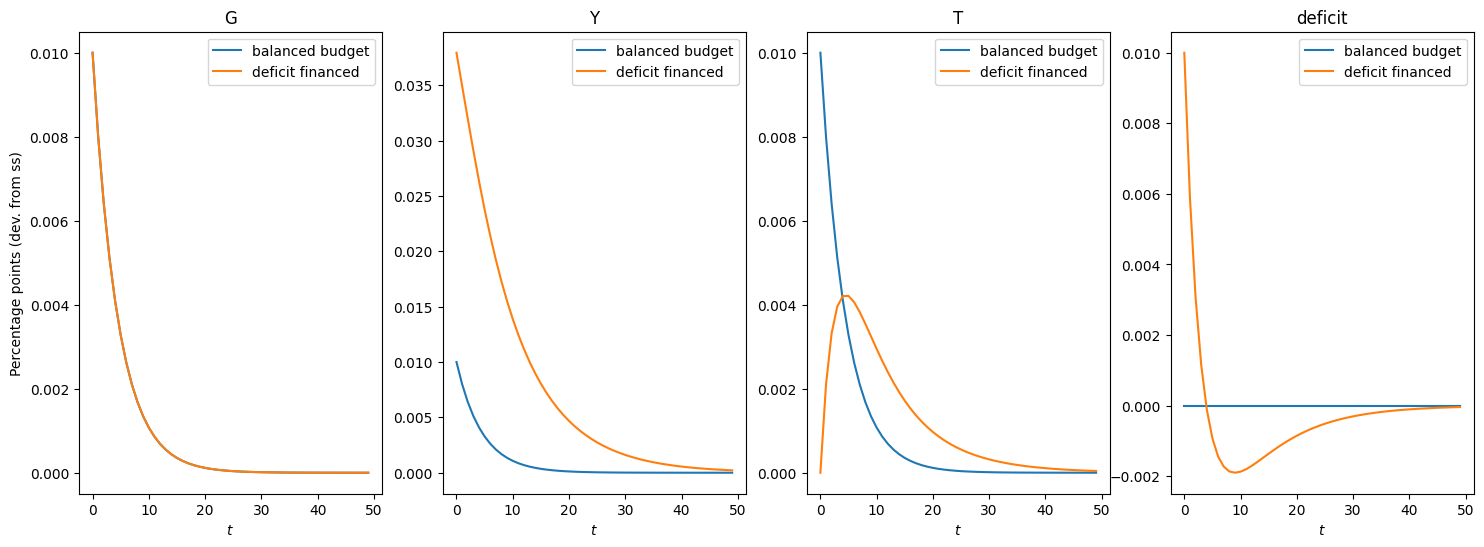

In [19]:
show_irfs([irfs_G_lin, irfs_B_lin], ['G', 'Y','T', 'deficit'], labels=["balanced budget", "deficit financed"])


## Nonlinear Impulse Responses

In [20]:

def hh(Z):
    C,A = Agent_GE.calc_agg_path(Z,300)
    return C,A


In [21]:
from Misc_Utilities.simple_block import exog # import wrapper so SSJ can identify hark household object

hh_block = exog(Jacobian_Dict,hh,hh)
hh_block.name = hh

ha = sj.create_model([hh_block,fiscal,mkt_clearing], name="HA Model")
irfs_G_nonlin = ha.solve_impulse_nonlinear(SteadyState_Dict, unknowns_td, targets_td, shocks)


ModuleNotFoundError: No module named 'Misc_Utilities'

In [ ]:
plt.plot(irfs_G_nonlin['Y'], label ='nonlinear')
plt.plot(irfs_G_lin['Y'], label = 'linear', linestyle='--')
plt.xlim(-1,50)
plt.legend()
plt.title('Nonlinear Impulse responses of output')
plt.show()

In [ ]:
show_irfs([irfs_G_lin,irfs_G_nonlin], ['G', 'Y','T'], ['Linear', 'Nonlinear'])